### В данном проекте передо мной стояла задача построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

Данные о клиентах банка:

age (возраст);\
  job (сфера занятости);\
marital (семейное положение);\
education (уровень образования);\
default (имеется ли просроченный кредит);\
housing (имеется ли кредит на жильё);\
loan (имеется ли кредит на личные нужды);\
balance (баланс)

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

contact (тип контакта с клиентом);\
month (месяц, в котором был последний контакт);\
day (день, в который был последний контакт);\
duration (продолжительность контакта в секундах).

Прочие признаки:

campaign (количество контактов с этим клиентом в течение текущей кампании);\
pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);\
previous (количество контактов до текущей кампании)\
poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

# Проект: классификация

In [217]:
# Импортируем необходимые библиотеки 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('bank_fin.csv', sep = ';')

In [3]:
# исследуем датасет на наличие пропусков
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


Пропуски у нас есть в признаке "balance", выясним сколько их:

In [4]:
df['balance'].isnull().value_counts()

balance
False    11137
True        25
Name: count, dtype: int64

Итак, в признаке баланса имеем 25 пропусков

### Задание 2

In [5]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts(normalize=True)*100

job
management       22.988712
blue-collar      17.416234
technician       16.332199
admin.           11.951263
services          8.269127
retired           6.970077
self-employed     3.628382
student           3.225228
unemployed        3.198352
entrepreneur      2.938541
housemaid         2.454757
unknown           0.627128
Name: proportion, dtype: float64

Несмотря на отсутствие явных пропусков в данных, мы имеем аналог пропуска, который обозначен как unknown  и у нас как минимум 0.6% пропусков в таком виде

### Задание 3

In [6]:
# Признак баланса имеет как строковые значения так и числовые, поэтому преобразуем все к строковому типу данных
df['balance']=df['balance'].astype('str')

In [7]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def balance_replaced(arg):
    if arg == np.nan:
        return arg
    else:
        arg = float((arg.replace(' ','')).replace(',00','').replace('$',''))
        return arg
df['balance']=df['balance'].apply(balance_replaced)       

In [8]:
df['balance']=df['balance'].astype('float')

In [9]:
round(df['balance'].mean(),3)

1529.129

### Задание 4

In [10]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())

In [11]:
round(df['balance'].mean(),3)

1526.936

### Задание 5

In [12]:
df['job'].mode()

0    management
Name: job, dtype: object

In [13]:
df['education'].mode()

0    secondary
Name: education, dtype: object

In [14]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].apply(lambda x: 'management' if x == 'unknown' else x)

In [15]:
df['education'] = df['education'].apply(lambda x: 'secondary' if x == 'unknown' else x)

In [16]:
mask = (df['job'] == 'management') & (df['education'] == 'secondary')
round(df['balance'][mask].mean(),3)

1598.883

### Задание 6

In [17]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = np.percentile(x,25), np.percentile(x,75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned
outliers, df = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df.shape[0]}')

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


Text(0.5, 1.0, 'Cleaned Full Square Boxplot')

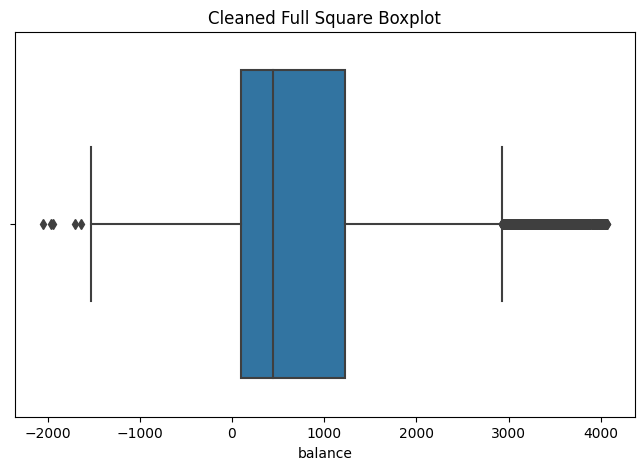

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
boxplot = sns.boxplot(data=df, x='balance', ax=axes);
boxplot.set_title('Cleaned Full Square Boxplot')

## Часть 2:  Разведывательный анализ

### Задание 1

In [19]:
df['deposit'].value_counts()

deposit
no     5424
yes    4681
Name: count, dtype: int64

In [20]:
fig = px.histogram(df, x="deposit",title= 'Распределение целевого признака')
fig.show()

Из данных выше можно сделать вывод, что целевая переменная распределенна сбалансированна 

### Задания 2 и 3

In [21]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'balance'}>,
        <Axes: title={'center': 'day'}>],
       [<Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'campaign'}>,
        <Axes: title={'center': 'pdays'}>],
       [<Axes: title={'center': 'previous'}>, <Axes: >, <Axes: >]],
      dtype=object)

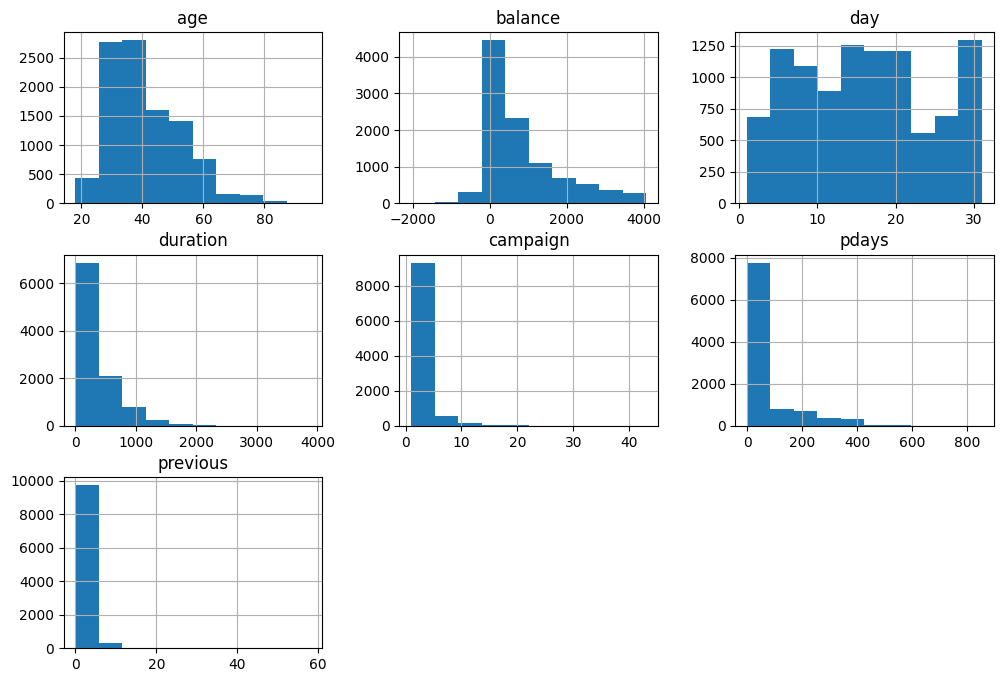

In [22]:
df.hist(figsize=(12,8))


Из графиков видно что все наши числовые признаки распределены ненормально. Из описательной статистики можно выделить следующие момменты:
1) Максимальный возраст = 95 годам, сомнительно, конечно, но в целом есть вероятность клиента такого возраста
2) Минимальное значение баланса является отрицательным числом, либо это выброс, либо интересная особенность работы банка
3) Максимальная продолжительность составила чуть больше часа



### Задания 4 и 5

In [23]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df.describe(include=['O'])

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


In [24]:
fig = make_subplots(rows=4, cols=3,subplot_titles=(
    'Job','marital','education','','housing','loan','contact','month','poutcome','default','','deposit'))
job = go.Histogram(x=df['job'])
marital = go.Histogram(x=df['marital'])
education = go.Histogram(x=df['education'])
default = go.Histogram(x=df['default'])
housing = go.Histogram(x=df['housing'])
loan = go.Histogram(x=df['loan'])
contact = go.Histogram(x=df['contact'])
month = go.Histogram(x=df['month'])
poutcome = go.Histogram(x=df['poutcome'])
deposit = go.Histogram(x=df['deposit'])

fig.append_trace(job, 1, 1)
fig.append_trace(marital, 1, 2)
fig.append_trace(education, 1, 3)
fig.append_trace(housing, 2, 2)
fig.append_trace(loan, 2, 3)
fig.append_trace(contact, 3, 1)
fig.append_trace(month, 3, 2)
fig.append_trace(poutcome, 3, 3)
fig.append_trace(default, 4, 1)
fig.append_trace(deposit, 4, 3)

fig.update_layout(height=800, width=800, title_text="Статистика по  категориальным признакам")
fig.show()

Наиболее распространенная сфера в которой работают клиенты - менеджмент. Превалирующая масса клиентов состоит в браке и имеет среднее образование. Почти половина всех клиентов имеют ипотеку, но не имеют потребительского кредита. Наибольшее количество контакта банка с клиентом пришлось на май, вероятно, что в этом месяце была какая-то программа. Также очень малая часть клиентов банка имеют просроченный кредит

### Задание 6

<Axes: xlabel='poutcome'>

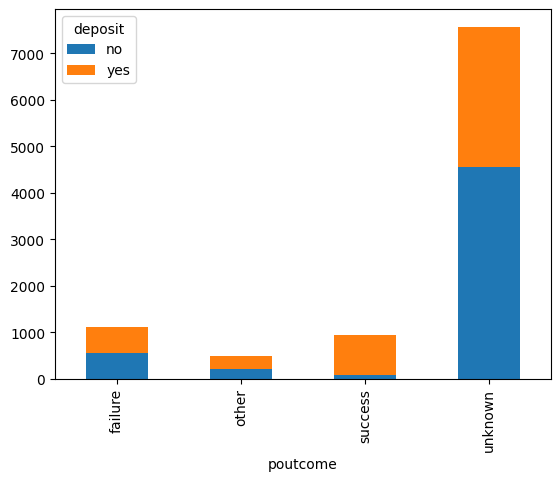

In [26]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

types = df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

Итак, статус предыдущей компании, для которой успех значительно превалирует над количеством неудач - success

### Задание 7

In [27]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
for i in np.unique(df.month):
    print(i, df[(df.month == i)&(df.deposit == 'no')].shape[0]/df[(df.month == i)].shape[0] *100)

apr 38.19277108433735
aug 55.95667870036101
dec 9.67741935483871
feb 45.55712270803949
jan 60.81504702194357
jul 58.956276445698165
jun 54.891304347826086
mar 10.126582278481013
may 67.86396637371035
nov 58.46153846153847
oct 18.507462686567163
sep 16.546762589928058


Май имеет наибольшее количество отказов от предложений открыть депозит, данный результат, наверное, можно связать с какими-то праздниками в стране, где располагается банк

### Задание 8

In [28]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def age(arg):
    if arg < 30:
        return '<30'
    elif 30 <= arg < 40:
        return '30-40'
    elif 40 <= arg < 50:
        return '40-50'
    elif 50 <= arg < 60:
        return '50-60'
    elif arg >= 60:
        return '60+'
df['age']= df['age'].apply(age)   
 

In [29]:
fig = px.histogram(df, x="age", color="deposit",title= 'Распределение открытия депозита в разрезе возраста')
fig.show()

Наиболее редко отказы по открытию депозита получают от возрастной группы 60+ и людей младше 30 лет

### Задания 9 и 10

In [30]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
fig = px.histogram(df, x="marital", color="deposit",title='Распределение открытия депозита в зависимости от cемейного положения')
fig.show()

In [31]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
fig = px.histogram(df, x="education", color="deposit",title='Распределение открытия депозита в зависимости от образования')
fig.show()

In [32]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig = px.histogram(df, x="job", color="deposit",title='Распределение открытия депозита в зависимости от сферы работы')
fig.show()

Одинокие люди отказываются реже от открытия депозита, много людей также соглашается из сферы работы менеджмента и рабочего класса. Люди с среднем образованием открывают депозит чаще по сравнению с людьми с высшим образованием.

### Задание 11

In [33]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
pivot = pd.pivot_table(
    df,
    index = 'education',
    columns = 'marital',
    values= 'deposit',
    aggfunc= 'count')
pivot

marital,divorced,married,single
education,,,
primary,187,980,182
secondary,653,3119,1745
tertiary,337,1616,1286


## Часть 3: преобразование данных

### Задание 1

In [34]:
# преобразуйте уровни образования
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['education'] = label_encoder.fit_transform(df['education'])

In [35]:
# преобразуем признак возраста 
df['age'] = label_encoder.fit_transform(df['age'])

### Задания 2 и 3

In [36]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df['deposit'] = df['deposit'].apply(lambda x: 1 if x== 'yes' else 0)

In [37]:
round(df['deposit'].std(),3)

0.499

In [38]:
df['default'] = df['default'].apply(lambda x: 1 if x== 'yes' else 0)

In [39]:
df['housing'] = df['housing'].apply(lambda x: 1 if x== 'yes' else 0)

In [40]:
df['loan'] = df['loan'].apply(lambda x: 1 if x== 'yes' else 0)

In [41]:
sum_4_3 = round(df['default'].mean() + df['housing'].mean() + df['loan'].mean(),3)
sum_4_3

0.635

### Задание 4

In [43]:
df = pd.get_dummies(df)

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int64  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  job_admin.         10105 non-null  bool   
 13  job_blue-collar    10105 non-null  bool   
 14  job_entrepreneur   10105 non-null  bool   
 15  job_housemaid      10105 non-null  bool   
 16  job_management     10105 no

### Задания 5 и 6

По заданиям с платформы корреляция определяется методом Пирсона, с чем я не согласен, так как наши данные не имеют нормального распределения и считать корреляцию методом Пирсона, является неправильным ходом решения, поэтому буду считать посредством корреляции Спирмана.

In [114]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
df_corr = df.corr('spearman')
df_corr = df_corr['deposit'].reset_index()
sort_corr = df_corr.sort_values('deposit', ascending=False)
sort_corr.head()

,index,deposit
11,deposit,1.000000
7,duration,0.532450
43,poutcome_success,0.288491
10,previous,0.227831
26,contact_cellular,0.223944


In [103]:
fig = px.bar(sort_corr, x='index', y='deposit',title = 'Значения коэффициентов корреляции для целевой переменной')
fig.update_layout(height=600, width=900)

fig.show()

In [112]:
fig = px.imshow(df.corr('spearman'),text_auto=True)
fig.update_layout(height=900, width=900)
fig.show()

С помощью тепловой карты тяжело, конечно, определить коэффициенты корреляции, но благодаря столбчатой диаграммы можно сделать вывод, что наш целевой признак имеет наибольшую корреляцию с duration, poutcome_success и previous.

### Задания 7 и 8

In [115]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [120]:
# Узнаем размер тестовой выборк
X_test.shape[0]

3335

In [124]:
# Узнаем среднее значение целевой переменной на тестовой выборке
round(y_test.mean(),2)

0.46

### Задание 9

In [128]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
features_skb=selector.get_feature_names_out()

In [129]:
X_train = X_train[features_skb]
X_test = X_test[features_skb]

### Задание 10

In [134]:
# нормализуйте данные с помощью minmaxsxaler
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train)
X_train_scaled = mm_scaler.transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)
X_test_scaled[:, 1].mean().round(2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [141]:
# обучите логистическую регрессию и рассчитайте метрики качества
from sklearn import linear_model
log_reg_full = linear_model.LogisticRegression(solver='sag',random_state=42, max_iter=1000)
log_reg_full.fit(X_train_scaled, y_train)
y_train_predict = log_reg_full.predict(X_train_scaled)
y_test_predict = log_reg_full.predict(X_test_scaled)

print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_predict)))
      

Accuracy: 0.80


### Задания 2,3,4

In [142]:
# обучите решающие деревья, настройте максимальную глубину
#Создаём объект класса DecisionTreeClassifier
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности 
    random_state=42 #генератор случайных чисел
)
#Обучаем дерево решений по алгоритму CART
dt_clf.fit(X_train_scaled, y_train)
y_train_predict = dt_clf.predict(X_train_scaled)
y_test_predict = dt_clf.predict(X_test_scaled)

print('Accuracy on train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_predict)))
print('Accuracy on test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_predict)))

Accuracy on train: 1.00
Accuracy on test: 0.75


In [156]:
#Создаём объект класса DecisionTreeClassifier
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности 
    random_state=42, #генератор случайных чисел
    max_depth=6
)
#Обучаем дерево решений по алгоритму CART
dt_clf.fit(X_train_scaled, y_train)
y_train_predict = dt_clf.predict(X_train_scaled)
y_test_predict = dt_clf.predict(X_test_scaled)

print('Accuracy on train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_predict)))
print('Accuracy on test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_predict)))

Accuracy on train: 0.82
Accuracy on test: 0.81


### Задание 5

In [178]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
param_grid = [{'min_samples_split': [2, 5, 7, 10],
    'max_depth':[3,5,7]}
]

In [188]:
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        random_state=42, #генератор случайных чисел
        criterion='entropy'
    ), 
    param_grid=param_grid, 
    n_jobs = -1
)

In [189]:
grid_search.fit(X_train_scaled, y_train) 

GridSearchCV(estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=42),
             n_jobs=-1,
             param_grid=[{'max_depth': [3, 5, 7],
                          'min_samples_split': [2, 5, 7, 10]}])

In [190]:
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.81


In [187]:
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 5}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [191]:
# обучите на ваших данных случайный лес
#Создаём объект класса RandomForestClassifier
rf_clf_2d = ensemble.RandomForestClassifier(
    n_estimators=100, #число деревьев
    criterion='gini', #критерий эффективности
    max_depth=10, #максимальная глубина дерева
    min_samples_leaf = 5, #число признаков из метода случайных подпространств
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf_2d.fit(X_train_scaled, y_train)
 
#Делаем предсказание класса
y_pred = rf_clf_2d.predict(X_test_scaled)
#Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [198]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(
    learning_rate = 0.05, # темп обучения
    n_estimators = 300, # количество деревьев в ансамбле
    min_samples_leaf = 5, # минимальное количество листьев
    max_depth = 5, # максимальная глубина дерева
    random_state = 42 # генератор случайных чисел
)
gb.fit(X_train_scaled,y_train)
y_pred = gb.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [207]:
# объедините уже известные вам алгоритмы с помощью стекинга 
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import RidgeCV


### Задание 5

In [204]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
estimators = [
    ('lr', linear_model.LogisticRegression(solver='sag',random_state=42, max_iter=1000)),
    ('dt',  tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности 
    random_state=42, #генератор случайных чисел
    max_depth=6
)),
     ('gb', GradientBoostingClassifier(
    learning_rate = 0.05, # темп обучения
    n_estimators = 300, # количество деревьев в ансамбле
    min_samples_leaf = 5, # минимальное количество листьев
    max_depth = 5, # максимальная глубина дерева
    random_state = 42 # генератор случайных чисел
))]


In [209]:
reg = StackingClassifier(
    estimators=estimators, #базовые модели в стекинге
    final_estimator=linear_model.LogisticRegression( #метамодель                
        random_state=42 #датчик генератора случайных чисел
    )
)
# Обучаем модель
reg.fit(X_train_scaled, y_train)
y_pred = reg.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1790
           1       0.80      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задания 6,7,8

In [214]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 10)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2,10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))
  

  return score

In [215]:
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2024-03-10 20:11:24,632] A new study created in memory with name: RandomForestClassifier
[I 2024-03-10 20:11:24,987] Trial 0 finished with value: 0.8564271175825896 and parameters: {'n_estimators': 100, 'max_depth': 24, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8564271175825896.
[I 2024-03-10 20:11:25,372] Trial 1 finished with value: 0.8655134798192301 and parameters: {'n_estimators': 110, 'max_depth': 29, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8655134798192301.
[I 2024-03-10 20:11:25,907] Trial 2 finished with value: 0.8613892365456821 and parameters: {'n_estimators': 160, 'max_depth': 17, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8655134798192301.
[I 2024-03-10 20:11:26,434] Trial 3 finished with value: 0.9202069289857344 and parameters: {'n_estimators': 130, 'max_depth': 22, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.9202069289857344.
[I 2024-03-10 20:11:27,029] Trial 4 finished with value: 0.9136420525657072 and parameters: {'n_

In [216]:
# рассчитаем точность для тестовой выборки
model_rf_opt = ensemble.RandomForestClassifier(**study.best_params, random_state=42)
model_rf_opt.fit(X_train_scaled, y_train)

# делаем предсказание и рассчитываем метрику
y_test_pred_rf_opt = model_rf_opt.predict(X_test_scaled)
print('f1_score на тестовом наборе для модели случайного леса: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_rf_opt)))
print("accuracy на тестовом наборе: {:.2f}".format(model_rf_opt.score(X_test_scaled, y_test)))

f1_score на тестовом наборе для модели случайного леса: 0.82
accuracy на тестовом наборе: 0.83
